In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Loading synthetic data

We will be loading simulated Hawkes data.

In [7]:
import glob
import pickle

In [8]:
glob.glob('../data/simulated/*')

['../data/simulated/hawkes_synth_data_1d.pkl',
 '../data/simulated/hawkes_synth_data_2d.pkl',
 '../data/simulated/README.md']

In [9]:
from load_synth_data import process_loaded_sequences, one_hot_embedding

## 1D process

In [10]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_1d.pkl", "rb") as f:
    loaded_hawkes_data = pickle.load(f)

In [11]:
loaded_hawkes_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [12]:
mu = loaded_hawkes_data['mu']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print(mu)
print(decay)
print(tmax)

1.0
5.0
60.0


In [13]:
times_tensor, types_tensor, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data)

## 2D process

In [408]:
# Load data simulated using tick
with open("../data/simulated/hawkes_synth_data_2d.pkl", "rb") as f:
    loaded_hawkes_2d_data = pickle.load(f)

In [409]:
loaded_hawkes_2d_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

In [421]:
print(loaded_hawkes_2d_data['mu'])
print(loaded_hawkes_2d_data['alpha'])
print(loaded_hawkes_2d_data['decay'])
tmax = loaded_hawkes_2d_data['tmax']
print(f"tmax: {tmax}")

[0.7 1. ]
[[0.1  0.15]
 [0.01 0.01]]
0.01
tmax: 60.0


In [469]:
times_tensor, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_2d_data)

onehot_types = one_hot_embedding(seq_types, 3)

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= \sigma(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [484]:
from models.decayrnn import HawkesDecayRNN
from train_functions import train_decayrnn

In [485]:
hidden_size = 16
model = HawkesDecayRNN(2, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.013)

In [486]:
# define training data
train_size = int(0.6*times_tensor.size(1))
print("Train size %d" % train_size)

train_times_tensor = times_tensor[:, :train_size]
train_onehot_types = onehot_types[:, :train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_onehot_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 1200
Train event times shape torch.Size([167, 1200])
Train event types shape torch.Size([167, 1200, 3])
Train seq lengths shape torch.Size([1200])


In [487]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 40

loss_hist = train_decayrnn(model, optimizer, train_times_tensor,
                           train_onehot_types, train_seq_lengths, tmax,
                           BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 32
Number of epochs 50


Text(0, 0.5, 'Loss')

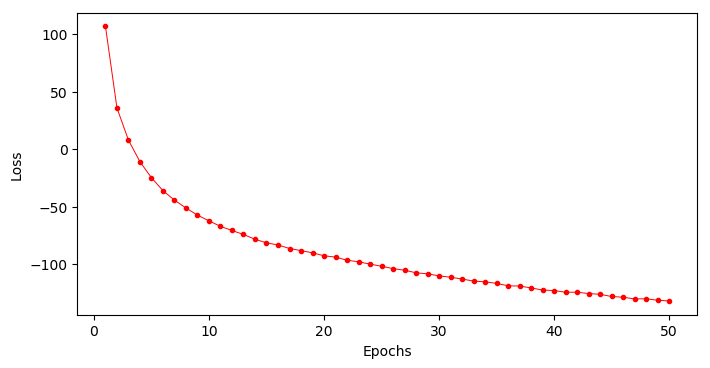

In [488]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
epochs_range = list(range(1, EPOCHS+1))
ax.plot(epochs_range, loss_hist, color='red',
         linewidth=.7, marker='.', markersize=6)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [489]:
from models.decayrnn import generate_sequence

In [490]:
gen_event_times, gen_event_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)

In [499]:
# Build a statistic for the no. of events
gen_seq_lengths = []
n_gen_seq = 500 # number of generated sequences
for i in range(n_gen_seq):
    (gen_event_times, gen_event_types,
     gen_event_intens, gen_event_decay) = generate_sequence(model, tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)
gen_seq_lengths = np.array(gen_seq_lengths)

print("Mean generated sequence length: {}".format(gen_seq_lengths.mean()))
print("Generated sequence length std. dev: {}".format(gen_seq_lengths.std()))
MODEL_NAME = "Decay-RNN"

Mean generated sequence length: 35.26
Generated sequence length std. dev: 6.346999291003584


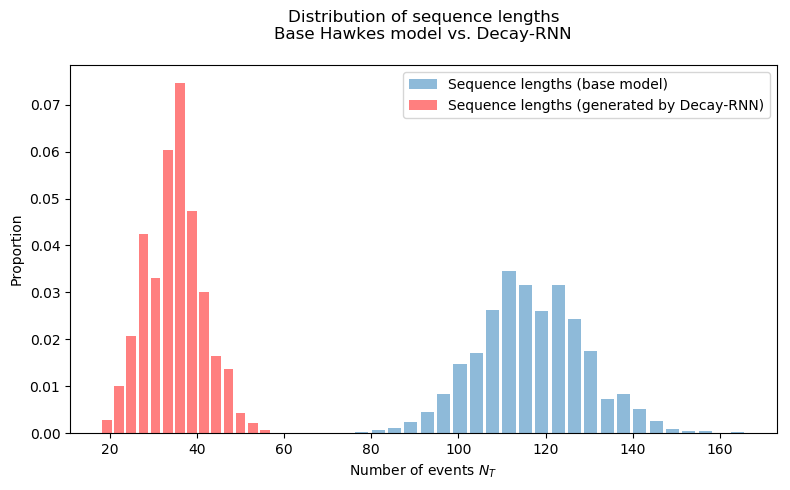

In [496]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
_ = ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
_ = ax.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            rwidth=0.8, alpha=0.5, color='red', density=True)
ax.legend()
ax.set_ylabel('Proportion')
ax.set_xlabel('Number of events $N_T$')
ax.set_title("""Distribution of sequence lengths
Base Hawkes model vs. {:}
""".format(MODEL_NAME))
fig.tight_layout()

In [500]:
RESULT_BASEDIR = "../results"
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}.{:}.pdf".format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME))

The number of events does not fit.

In [501]:
def plot_events_and_intensity(event_times: torch.Tensor, seq_types: torch.Tensor,
                              hidden_states: torch.Tensor, event_decay: torch.Tensor):
    sequence_length = event_times.shape[0]
    print("no. of events: {}".format(sequence_length))
    evt_times = event_times.numpy()
    evt_types = seq_types.numpy()
    inp_size = model.input_size
    fig, ax = plt.subplots(1, 1, sharex=True, dpi=110,
                                   figsize=(10,1))
    ax.set_ylim((-0.6, 1.6))
    ts_y = np.random.rand(sequence_length)
    inpt_size = model.input_size
    for k in range(inpt_size):
        mask = evt_types == k
        ax.scatter(evt_times[mask], ts_y[mask], s=9, cmap=cmap,
                   label="{}".format(k), alpha=0.7)
        ax.vlines(evt_times[mask], -0.6, 1.6, linewidth=0.3, linestyles='--', alpha=0.5)
    ax.legend()

no. of events: 26


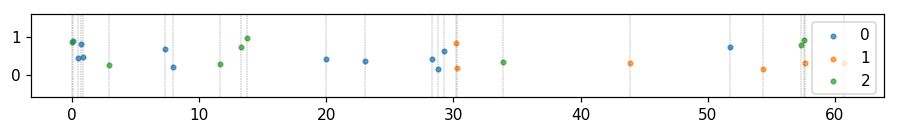

In [502]:
gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay = generate_sequence(model, tmax)
plot_events_and_intensity(gen_evt_times, gen_evt_types, gen_event_intens, gen_event_decay)

In [503]:
from models.decayrnn import read_predict

In [566]:
index = 0
print("Running next event type prediction for seq. #{}".format(index))
sl = seq_lengths[index]

print("For event #{} (seq. length-1, time {:.3f}), type is {}, next one is padding".format(
    sl-1, times_tensor[sl-1, index], seq_types[sl-1, index]))
print("For event #{} (seq. length, time {:.3f}), type is {}, next one is padding".format(
    sl, times_tensor[sl, index], seq_types[sl, index]))

Running next event type prediction for seq. #0
For event #165 (seq. length-1, time 59.318), type is 1, next one is padding
For event #166 (seq. length, time 59.362), type is 0, next one is padding


In [567]:
read_predict(model, times_tensor[:,index],
             onehot_types[:,index], seq_lengths[index])

Sequence length: 166 => last index = 165
	event_seq_times shape: torch.Size([167, 1])
	event_seq_types shape: torch.Size([167, 1, 3])
	dt_seq shape: torch.Size([166, 1])
Last read event time: tensor([59.3181]) of type 1
Next event time: tensor([59.3624]) in tensor([0.0442]) secs
tensor([[1.6039e-07, 1.0000e+00, 1.9979e-07]])
Actual type: 0
Predicted type: 1


(tensor([[1., 0., 0.]]), tensor([[[0., 1., 0.]]]))